<a href="https://colab.research.google.com/github/danieldang1806/pydataset/blob/main/Airbnb_Value_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Value Rating: What are the influential factors?

<img src="https://s3.amazonaws.com/blog4.0/blog/wp-content/uploads/Feature-Image_The-Ultimate-Guide-to-Airbnb-Reviews@2x-2048x1195.png" width=600>

**1. Target audience:** on-going/ first-time Airbnb hosts in Los Angeles <br>
**2. Metric:** Value rating score <br>
**3. Flow of analysis:** <br>
Find out the factors that impact the value rating score, including:
- Size of listing
- Competitive rate
- Number of properties managed
- Amenities

## Python libraries and data import

### Import relevant Python libraries and adjust initial settings

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import gzip
import re

In [ ]:
pip install geopandas

In [3]:
import geopandas as gpd

In [4]:
pd.options.display.max_columns = None

In [5]:
sns.set_theme(style='whitegrid')

### Import datasets

Import main dataset called `listings.csv.gz` and assign data to a shorten name called `df`

In [6]:
#! wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-06-06/data/listings.csv.gz -P '/content/drive/MyDrive/Mid-term Project'

In [7]:
with gzip.open('/content/drive/MyDrive/Mid-term Project/listings.csv.gz') as a:
    df = pd.read_csv(a)

Import geojson file type of `neighbourhoods` in Los Angeles

In [8]:
#! wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-06-06/visualisations/neighbourhoods.geojson -P '/content/drive/MyDrive/Mid-term Project'

In [9]:
neighbourhoods = gpd.read_file('/content/drive/MyDrive/Mid-term Project/neighbourhoods.geojson')
print(neighbourhoods.head())

   neighbourhood   neighbourhood_group  \
0  Angeles Crest  Unincorporated Areas   
1          Acton  Unincorporated Areas   
2     Agua Dulce  Unincorporated Areas   
3         Athens  Unincorporated Areas   
4   Alondra Park  Unincorporated Areas   

                                            geometry  
0  MULTIPOLYGON (((-118.09667 34.47348, -118.0796...  
1  MULTIPOLYGON (((-118.20703 34.53902, -118.1894...  
2  MULTIPOLYGON (((-118.37822 34.48811, -118.3783...  
3  MULTIPOLYGON (((-118.29152 33.93096, -118.2916...  
4  MULTIPOLYGON (((-118.32651 33.89757, -118.3264...  


## Data wrangling

The overall process of this step is described by following points:
- Cleaning and String processing
- Correcting data type of some variables
- Renaming columns to a shorter form
- Missing data

In [10]:
# Clean and correct data type of variable: price
df['price'] = df['price'].str.strip('$')
df['price'] = df['price'].str.replace(',','').astype('float')

In [11]:
# String processing of variable: amenities
df['amenities'] = df['amenities'].str.replace('[','').str.replace(']','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [12]:
# Rename some columns to a shorter form
rename_col = {'neighborhood_overview': 'neighbourhood_overview',
              'host_is_superhost': 'superhost',
              'neighbourhood_cleansed': 'neighbourhood_city', 
              'neighbourhood_group_cleansed': 'neighbourhood_group', 
              'host_response_time': 'rep_time', 
              'host_response_rate': 'rep_rate',
              'host_acceptance_rate': 'accept_rate', 
              'review_scores_rating': 'rs_overall',
              'review_scores_accuracy': 'rs_accuracy',
              'review_scores_cleanliness': 'rs_cleanliness',
              'review_scores_checkin': 'rs_checkin',
              'review_scores_communication': 'rs_communication',
              'review_scores_location': 'rs_location',
              'review_scores_value': 'rs_value'}

df = df.rename(columns=rename_col)

In [13]:
# Drop missing rating score
df = df.dropna(subset=['rs_overall', 'rs_accuracy', 'rs_cleanliness', 'rs_checkin', 'rs_communication', 'rs_location', 'rs_value'])

Besides, we also need to limit the overall data to get the correct insights based on the analysis target

In [14]:
# Limit data of listings that have at least more than 1 review
df = df[df['number_of_reviews'] > 1]

In [15]:
# Limit data to short term rental listings only
# As definition of Airbnb, long term rental are 28 days or longer
df = df[(df['minimum_nights'] > 0) & (df['minimum_nights'] < 28)]

In [17]:
df['count_amenities'] = df['amenities'].apply(lambda x: len(re.split('", "',x)))

In [16]:
df.shape

(17199, 74)

After limiting the data, there are 17,199 rows till now. 

## Insights

### Size of listing

The definition of listing size here is used along with variable called `accommodates`, which is defined as the maximum capacity of the listing.


Firstly, let's have a look on the distribution of this variable:

In [18]:
df['accommodates'].describe()

count    17199.000000
mean         4.429385
std          3.051426
min          0.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         16.000000
Name: accommodates, dtype: float64

Then, we again limit the dataset which contains maximum capacity from at least 1 and above, and assign to `df_size`

In [19]:
# Limit accommodates to at least 1 and above
df_size = df[df['accommodates'] > 0]

Instead of plotting every single points (between `accommodates` and `rs_value`) to the graph, in order to see a much clearer picture, we will group all the points for each value of one variable by the aggregation of the metric. <br>

For example, as `accommodates` of the dataset varies from 1 to 16, we first group all observations of `accommodates` as 1 by calculating the median of value rating of these observations. As a result, we will get 4.83 as the median rating score for all observations of `accommodates` = 1.

In [20]:
# Group accommodates with aggregation of value rating and assign to: plot_acc
plot_acc = df_size.groupby('accommodates').agg({'rs_value':'median', 'id':'count'}).reset_index()
plot_acc

,accommodates,rs_value,id
0,1,4.830,1206
1,2,4.840,5506
2,3,4.810,1205
3,4,4.790,2986
4,5,4.780,910
5,6,4.750,2105
6,7,4.750,448
7,8,4.770,1281
8,9,4.780,211
9,10,4.770,597


Now, we can plot above this table into the regression plot to see whether there is any trends existed. 

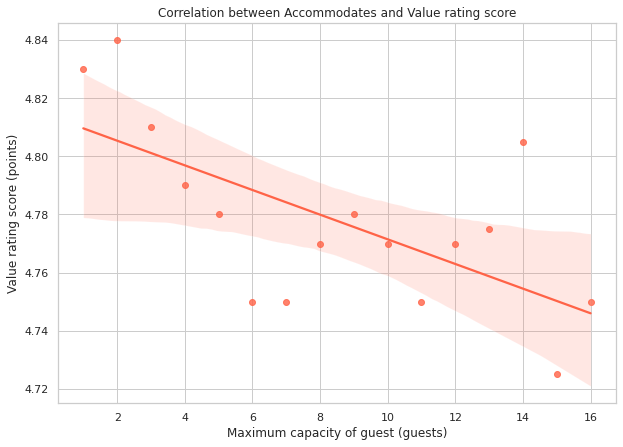

In [21]:
plt.figure(figsize=(10,7))
sns.regplot(data=plot_acc, x='accommodates', y='rs_value', color='tomato')
plt.title('Correlation between Accommodates and Value rating score')
plt.xlabel('Maximum capacity of guest (guests)')
plt.ylabel('Value rating score (points)')
plt.show()

We can see a negative correlation between `accommodates` and `rs_value`. Listings that can accommodate a high number of guests get lower value rating than listings with maximum capacity of 3 guests or below.

In an article called "The Elements of Value" published on HRB Review on September 2016, the authors started their article with a declaration to show a relationship between value and price: <br><br>
***When customers evaluate a product or service, they weigh its perceived value against the asking price.*** <br>

Eric Almquist, John Senior, and Nicolas Bloch (Sep 2016). The Elements of Value. Harvard Business Review. https://hbr.org/2016/09/the-elements-of-value

By referring to this definition, back to this analysis, we realize there might be a trend in common between value rating and price. Let's visualize `accommodates` and `price` on boxplot chart. 

In [22]:
df_size_short = df_size[['accommodates', 'price']]

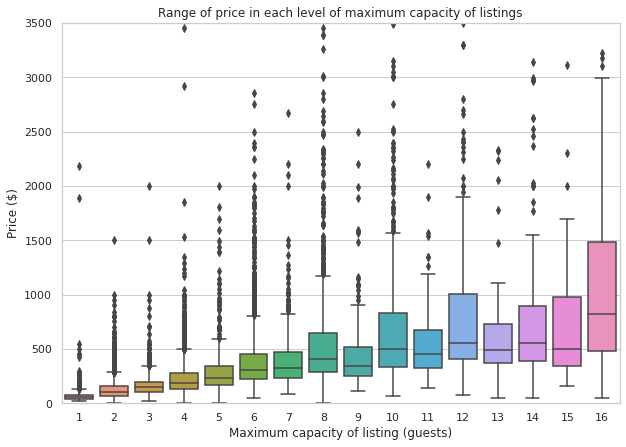

In [23]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df_size, x='accommodates', y='price')
plt.ylim(0,3500)
plt.title('Range of price in each level of maximum capacity of listings')
plt.ylabel('Price ($)')
plt.xlabel('Maximum capacity of listing (guests)')
plt.show()

Overall, we can see that the position of box plot in more `accommodates` tend to get higher places, which means the price goes up with the increasing of listing size. <br>
Moreover, listings that can accommodates up to 4 guests and above have a long length of box, which also means a much wider range of price than listings with maximum capacity of 3 guests or below.

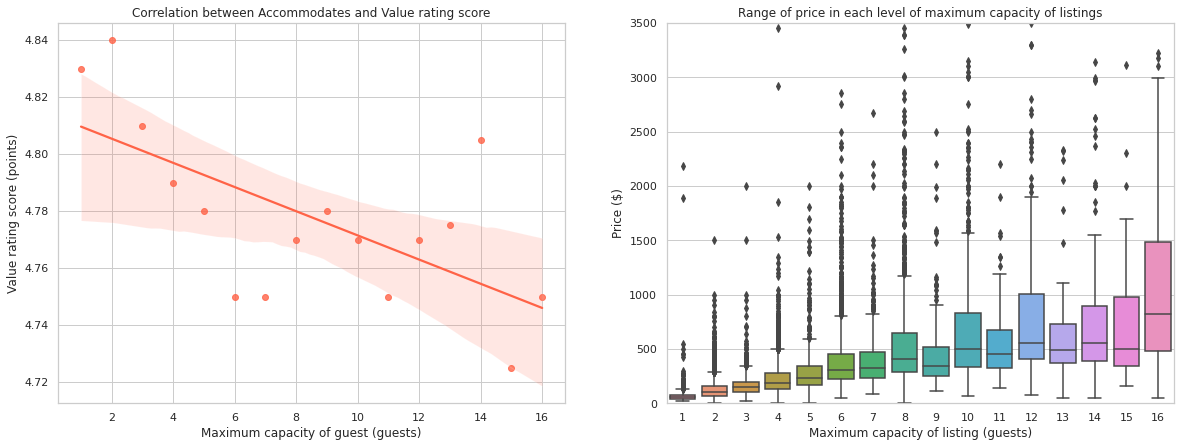

In [24]:
plt.figure(figsize=(20,7))

plt.subplot(121)
sns.regplot(data=plot_acc, x='accommodates', y='rs_value', color='tomato')
plt.title('Correlation between Accommodates and Value rating score')
plt.xlabel('Maximum capacity of guest (guests)')
plt.ylabel('Value rating score (points)')

plt.subplot(122)
sns.boxplot(data=df_size, x='accommodates', y='price')
plt.ylim(0,3500)
plt.title('Range of price in each level of maximum capacity of listings')
plt.ylabel('Price ($)')
plt.xlabel('Maximum capacity of listing (guests)')

plt.show()

By putting 2 graphs next to each other, in general, listings with a high maximum capacity of guests have higher price levels with wider range of price but get a lower score on median average in value rating than listings accommodating less guests. 

In order to explain the above idea more clearly, we can limit and compare data between listings can take up to 16 guests and 2 guests seperately as an ideal example with below characterisctic: 
- must be in same place (`neighbourhood_city`)
- must be in the same market segmentation (`room_type`) 

We can limit data to places where hosts are setting maximum capacity of guests at 2 and 16, with the type of room is Entire home/apt. 

In [25]:
df_acc_compare = df[((df['accommodates'] == 2) | (df['accommodates'] == 16)) & (df['room_type'] == 'Entire home/apt')]

In [26]:
acc_table = pd.pivot_table(data=df_acc_compare, 
               index='neighbourhood_city',
               columns='accommodates', 
               values='id', 
               aggfunc='count')

acc_table = acc_table.dropna()

# Limit data to places where the supply of listing is at least 2 or above 
acc_neighbourhood_compare = acc_table[(acc_table[2] > 2) & (acc_table[16] > 2)]

acc_neighbourhood_compare  = acc_neighbourhood_compare.reset_index()

acc_neighbourhood_compare 

accommodates,neighbourhood_city,2,16
0,Anaheim,6.0,21.0
1,Beverly Crest,6.0,3.0
2,Downtown,22.0,3.0
3,Fullerton,4.0,8.0
4,Hollywood Hills,32.0,4.0
5,Newport Beach,41.0,11.0
6,Rowland Heights,10.0,9.0
7,Santa Ana,24.0,8.0
8,Sherman Oaks,22.0,5.0
9,Unincorporated Santa Monica Mountains,29.0,10.0


The above table show the number of listings that are accommodating at 2 and 16 guests in neighbourhoods that are available only. We can randomly select 2 places for data visualization. <br>

In this case, we will take **Anaheim** (where the supply of 16 guests of capacity surpasses the supply of 2) and **Sherman Oaks** (which is reversed to Anaheim) as examples:

In [27]:
df_acc16 = df[(df['accommodates'] == 16) & (df['room_type'] == 'Entire home/apt')]
df_acc2 = df[(df['accommodates'] == 2) & (df['room_type'] == 'Entire home/apt')]

In [28]:
df_acc16 = df_acc16[['neighbourhood_city', 'accommodates', 'price', 'rs_value']]
df_acc2 = df_acc2[['neighbourhood_city', 'accommodates', 'price', 'rs_value']]

In [29]:
anaheim_16 = df_acc16[df_acc16['neighbourhood_city'] == 'Anaheim']
anaheim_2 = df_acc2[df_acc2['neighbourhood_city'] == 'Anaheim']

In [30]:
sherman_16 = df_acc16[df_acc16['neighbourhood_city'] == 'Sherman Oaks']
sherman_2 = df_acc2[df_acc2['neighbourhood_city'] == 'Sherman Oaks']

In [31]:
anaheim_data = pd.concat([anaheim_16, anaheim_2], axis=0)
sherman_data = pd.concat([sherman_16, sherman_2], axis=0)

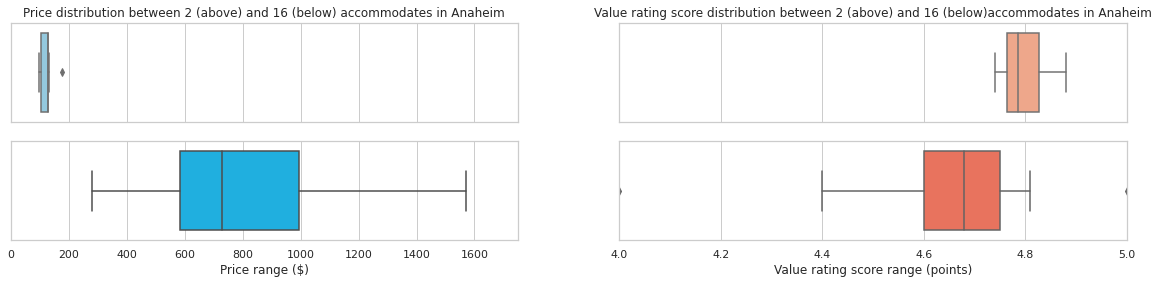

In [32]:
# Data viz for Anaheim
plt.figure(figsize=(20,4))

plt.subplot(221)
ax1 = sns.boxplot(data=df_acc2[df_acc2['neighbourhood_city'] == 'Anaheim'], x='price', color='skyblue')
plt.xlim(0, 1750)
ax1.set(xlabel=None)
ax1.set(xticklabels=[])
plt.title('Price distribution between 2 (above) and 16 (below) accommodates in Anaheim')

plt.subplot(223)
ax3 = sns.boxplot(data=df_acc16[df_acc16['neighbourhood_city'] == 'Anaheim'], x='price', color='deepskyblue')
plt.xlim(0, 1750)
plt.xlabel('Price range ($)')

plt.subplot(222)
ax2 = sns.boxplot(data=df_acc2[df_acc2['neighbourhood_city'] == 'Anaheim'], x='rs_value', color='lightsalmon')
plt.xlim(4,5)
ax2.set(xlabel=None)
ax2.set(xticklabels=[])
plt.title('Value rating score distribution between 2 (above) and 16 (below)accommodates in Anaheim')

plt.subplot(224)
ax4 = sns.boxplot(data=df_acc16[df_acc16['neighbourhood_city'] == 'Anaheim'], x='rs_value', color='tomato')
plt.xlim(4,5)
plt.xlabel('Value rating score range (points)')

plt.show()

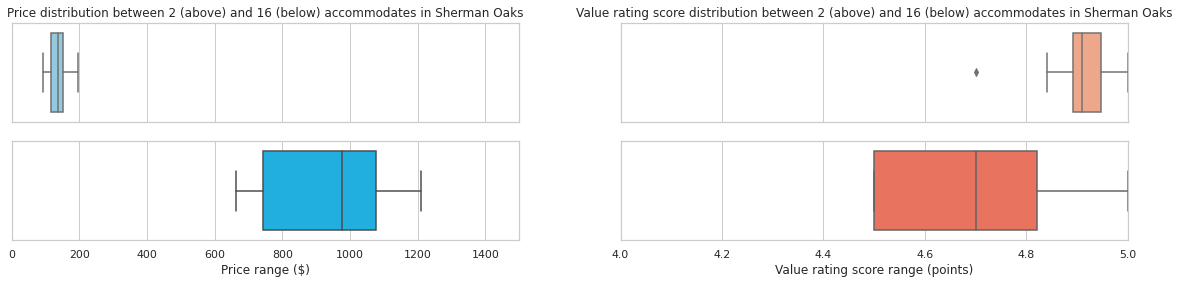

In [33]:
# Data viz for Sherman Oaks
plt.figure(figsize=(20,4))

plt.subplot(221)
ax1 = sns.boxplot(data=df_acc2[df_acc2['neighbourhood_city'] == 'Sherman Oaks'], x='price', color='skyblue')
plt.xlim(0, 1500)
ax1.set(xlabel=None)
ax1.set(xticklabels=[])
plt.title('Price distribution between 2 (above) and 16 (below) accommodates in Sherman Oaks')

plt.subplot(223)
ax3 = sns.boxplot(data=df_acc16[df_acc16['neighbourhood_city'] == 'Sherman Oaks'], x='price', color='deepskyblue')
plt.xlim(0, 1500)
plt.xlabel('Price range ($)')

plt.subplot(222)
ax2 = sns.boxplot(data=df_acc2[df_acc2['neighbourhood_city'] == 'Sherman Oaks'], x='rs_value', color='lightsalmon')
plt.xlim(4,5)
ax2.set(xlabel=None)
ax2.set(xticklabels=[])
plt.title('Value rating score distribution between 2 (above) and 16 (below) accommodates in Sherman Oaks')

plt.subplot(224)
ax4 = sns.boxplot(data=df_acc16[df_acc16['neighbourhood_city'] == 'Sherman Oaks'], x='rs_value', color='tomato')
plt.xlim(4,5)
plt.xlabel('Value rating score range (points)')

plt.show()

Overall, we can see that despite of different neighbourhoods, when there is a narrow range of price, the same pattern occurs to value rating and vice versa. <br>
However, in general, the clearer picture is that when there is a relatively similar price between listings, guests give quite the same score of value rating, and they are almost the high ones. <br> 
Meanwhile, when there is such a wide range of price varies from a low to extreme high price with many options offered accordingly, guests tend to give different ranges of score based on whether they felt these listings worth the money or not. 

In order to understand the above approach in Airbnb case, we can analysis the listing density in each neighbourhood to see if there is a lot choices in one neighbourhood, how will the value rating vary? 

### Number of listings in one neighbourhood

First, we count the number of listings and calculate median score of value rating in each neighbourhood from the main dataset.

In [34]:
neighbourhood_overview = df[['id', 'rep_rate', 'superhost', 'instant_bookable', 'neighbourhood_city', 'neighbourhood_group', 'latitude', 'longitude', 'rs_value']]

In [35]:
place_count = df.groupby('neighbourhood_city').agg({'id':'count', 'rs_value':'median'})

In [36]:
place_count = place_count.rename(columns={'id':'total_listings'})

In [37]:
place_count = place_count.reset_index()
place_count

,neighbourhood_city,total_listings,rs_value
0,Acton,5,4.97
1,Adams-Normandie,2,4.50
2,Agoura Hills,37,4.91
3,Agua Dulce,13,4.87
4,Alhambra,300,4.77
...,...,...,...
293,Wilmington,15,4.73
294,Windsor Square,5,4.91
295,Winnetka,24,4.86
296,Woodland Hills,79,4.82


As we already imported the geojson file of neighbourhood data, we will access it and calculate area (in square km) of each neighbourhood.

In [38]:
neighbourhoods

,neighbourhood,neighbourhood_group,geometry
0,Angeles Crest,Unincorporated Areas,"MULTIPOLYGON (((-118.09667 34.47348, -118.0796..."
1,Acton,Unincorporated Areas,"MULTIPOLYGON (((-118.20703 34.53902, -118.1894..."
2,Agua Dulce,Unincorporated Areas,"MULTIPOLYGON (((-118.37822 34.48811, -118.3783..."
3,Athens,Unincorporated Areas,"MULTIPOLYGON (((-118.29152 33.93096, -118.2916..."
4,Alondra Park,Unincorporated Areas,"MULTIPOLYGON (((-118.32651 33.89757, -118.3264..."
...,...,...,...
265,Windsor Square,City of Los Angeles,"MULTIPOLYGON (((-118.31359 34.07623, -118.3135..."
266,West Hills,City of Los Angeles,"MULTIPOLYGON (((-118.60374 34.23323, -118.6029..."
267,Whittier,Other Cities,"MULTIPOLYGON (((-118.06169 34.00487, -118.0613..."
268,Woodland Hills,City of Los Angeles,"MULTIPOLYGON (((-118.57644 34.18836, -118.5748..."


In [39]:
neighbourhoods['sq_km'] = neighbourhoods['geometry'].to_crs({'proj':'cea'}).area / 10**6

In [40]:
neighbourhoods_group = neighbourhoods.groupby('neighbourhood').sum(['sq_km']).reset_index()
neighbourhoods_group = neighbourhoods_group.rename(columns={'neighbourhood':'neighbourhood_city'})
neighbourhoods_group

,neighbourhood_city,sq_km
0,Acton,101.745423
1,Adams-Normandie,2.077936
2,Agoura Hills,20.480531
3,Agua Dulce,78.459236
4,Alhambra,19.767335
...,...,...
265,Willowbrook,9.768715
266,Wilmington,24.306708
267,Windsor Square,1.768159
268,Winnetka,12.434486


We then merge the above 2 groupby datasets into one based on the name of neighbourhood. We now can calculate the density by dividing total of listings to the area of each neighbourhood. 

In [41]:
place_data = pd.merge(place_count, neighbourhoods_group, how='inner', on='neighbourhood_city')

In [42]:
place_data['listings_per_sq_km'] = place_data['total_listings'] / place_data['sq_km']

In [43]:
place_data['diff_from_std'] = (place_data['rs_value'] - 4.8)

In [44]:
place_data = place_data.sort_values('listings_per_sq_km', ascending=False)

In [45]:
place_data['rounded'] = place_data['listings_per_sq_km'].round(0)

In [46]:
place_data

,neighbourhood_city,total_listings,rs_value,sq_km,listings_per_sq_km,diff_from_std,rounded
137,Marina del Rey,232,4.570,2.337741,99.241094,-0.230,99.0
245,West Hollywood,425,4.730,4.888131,86.945293,-0.070,87.0
230,Venice,351,4.790,7.899005,44.435978,-0.010,44.0
96,Hermosa Beach,89,4.730,3.772805,23.589874,-0.070,24.0
14,Avalon,167,4.530,7.694068,21.705034,-0.270,22.0
...,...,...,...,...,...,...,...
206,Southeast Antelope Valley,11,4.830,507.218784,0.021687,0.030,0.0
178,Ridge Route,11,4.900,765.028580,0.014379,0.100,0.0
152,Northeast Antelope Valley,10,4.790,1148.048582,0.008710,-0.010,0.0
219,Tujunga Canyons,5,4.700,599.646488,0.008338,-0.100,0.0


In order to plot the data on graph easily, we will group data into each density number (already rounded) and do aggregation on rating score.

In [47]:
rounded_density = place_data[place_data['rounded']>0].groupby('rounded').agg({'rs_value':'median', 'neighbourhood_city':'count'}).reset_index()

In [48]:
rounded_density

,rounded,rs_value,neighbourhood_city
0,1.0,4.830,68
1,2.0,4.840,35
2,3.0,4.830,17
3,4.0,4.840,17
4,5.0,4.835,13
5,6.0,4.800,9
6,7.0,4.820,7
7,8.0,4.775,7
8,9.0,4.820,5
9,10.0,4.800,3


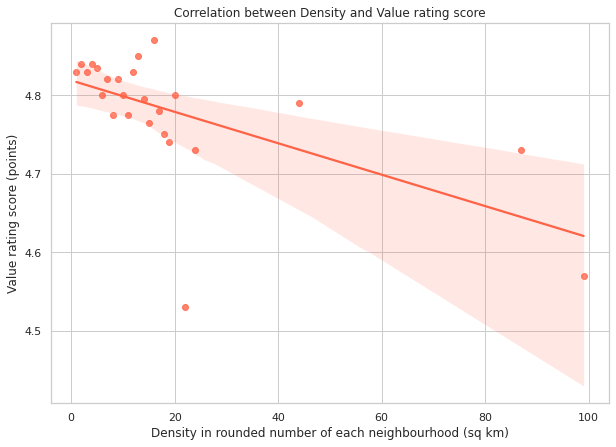

In [49]:
plt.figure(figsize=(10,7))
sns.regplot(data=rounded_density, x='rounded', y='rs_value', color='tomato')
plt.title('Correlation between Density and Value rating score')
plt.ylabel('Value rating score (points)')
plt.xlabel('Density in rounded number of each neighbourhood (sq km)')
plt.show()

There is a negative correlation between rating score and density. Locations with densely distributed have a lower rating score and locations with sparse density have relatively high score of value rating. 

In order to get a better view on how much of rating score that listings in each level of density are getting from guests, we can make a reference to a standard score of 4.8 (which is the requirement to overall rating score to [become a superhost](https://www.airbnb.com/help/article/829/how-to-become-a-superhost), but this number can be also used in this scale of analysis for better understanding on the performance of listings) and compare with average median score in each group.

In [50]:
rounded_density['diff_fr_std'] = ((rounded_density['rs_value'] - 4.8)/ 4.8) * 100

In [51]:
rounded_density['diff_fr_std'] = rounded_density['diff_fr_std'].round(1)

In [52]:
rounded_density['group'] = pd.cut(rounded_density['rounded'], 
                                  bins=[0.0,5,10,15,20,rounded_density['rounded'].max()], 
                                  labels=['1-5', '6-10', '11-15', '16-20', '+20'])

In [53]:
grouped_density = rounded_density.groupby('group')['diff_fr_std', 'rs_value'].mean().reset_index()
grouped_density

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,group,diff_fr_std,rs_value
0,1-5,0.70,4.835
1,6-10,0.06,4.803
2,11-15,0.06,4.803
3,16-20,-0.22,4.788
4,+20,-2.72,4.670


Based on the above result table, we then plot it to the graph so as to show how difference of value rating score from standard in each of group of density.

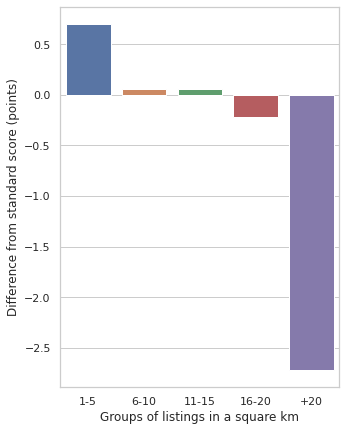

In [54]:
plt.figure(figsize=(5,7))
sns.barplot(data=grouped_density, x='group', y='diff_fr_std')
plt.xlabel('Groups of listings in a square km')
plt.ylabel('Difference from standard score (points)')
plt.show()

We can see that in places where listings are not much densly distributed (15 listings or below in one square km) tend to perform well in value rating score as the scores are all higher from 0.1% to 0.7% comparing to a standard 4.8 score. <br>
And when there is a high competitive rate in one square km (over 15 listings), value rating scores of these listings here are not highly evaluated as they are much lower than the standard score from 0.22% (group of 16-20 listings) to 2.72% (group of over 20 listings in one sq km) 

As being summed up from an article published on HBR about the outcome when there is a lot of choices:  <br><br>
***What’s more, psychologists and business academics alike have largely ignored another outcome of choice: More of it requires increased time and effort and can lead to anxiety, regret, excessively high expectations, and self-blame if the choices don’t work out.*** <br>
Barry Schwartz (June 2006). *More isn't always better*. Harvard Business Review. https://hbr.org/2006/06/more-isnt-always-better

As number of listings grow, hosts now can manage multiple properties by their owns or cooperate their counterparts. In the next analysis, we will see when one host has many listings to manage, will the value rating score go up or down? 

### Number of properties managed

In [55]:
df['host_listings_count'].describe()

count    17195.000000
mean        18.249549
std        110.920159
min          0.000000
25%          1.000000
50%          2.000000
75%          8.000000
max       2633.000000
Name: host_listings_count, dtype: float64

As the variable `host_listings_count` varies from 0 up to 2633, we will get rid of outliers for better analysis.

In [56]:
q1 = df['host_listings_count'].quantile(0.25)
q3 = df['host_listings_count'].quantile(0.75)

iqr = q3 - q1

lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

In [57]:
df_manage = df[(df['host_listings_count'] > 0) & (df['host_listings_count'] < upper)]

In [58]:
df_manage['host_listings_count'].describe()

count    11743.000000
mean         4.155838
std          4.108568
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         18.000000
Name: host_listings_count, dtype: float64

Same with above technique used, we also group data into each number of listings one host manage with aggregation of value rating score. 

In [59]:
plot_manage = df_manage.groupby('host_listings_count').agg({'rs_value':'median', 'host_id':'nunique'}).reset_index()

In [60]:
plot_manage

,host_listings_count,rs_value,host_id
0,1.0,4.850,3628
1,2.0,4.830,1433
2,3.0,4.810,704
3,4.0,4.800,357
4,5.0,4.770,255
5,6.0,4.750,166
6,7.0,4.700,100
7,8.0,4.770,74
8,9.0,4.695,55
9,10.0,4.690,47


Text(0, 0.5, 'Value rating score (points)')

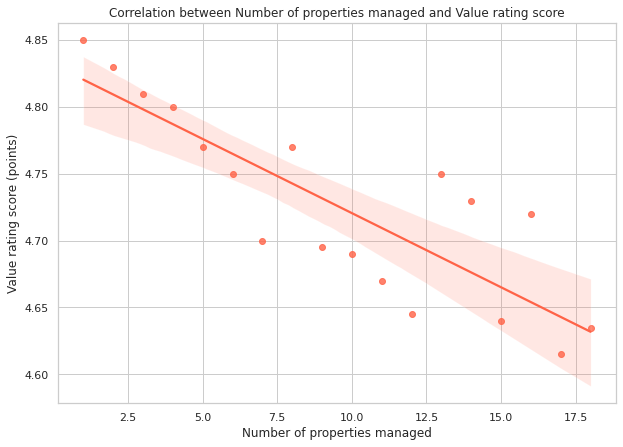

In [61]:
plt.figure(figsize=(10,7))
sns.regplot(data=plot_manage, x='host_listings_count', y='rs_value', color='tomato')
plt.title('Correlation between Number of properties managed and Value rating score')
plt.xlabel('Number of properties managed')
plt.ylabel('Value rating score (points)')

There is a negative correlation here. When a host has too many properties to manage, they tend to get lower value rating score than hosts manage only a few listings. 

We also compare that rating score in each level of properties managed to the standard score. 

In [62]:
plot_manage['diff_fr_std'] = ((plot_manage['rs_value'] - 4.8) / 4.8) * 100

In [63]:
plot_manage['host_listings_count'] = plot_manage['host_listings_count'].astype('int')

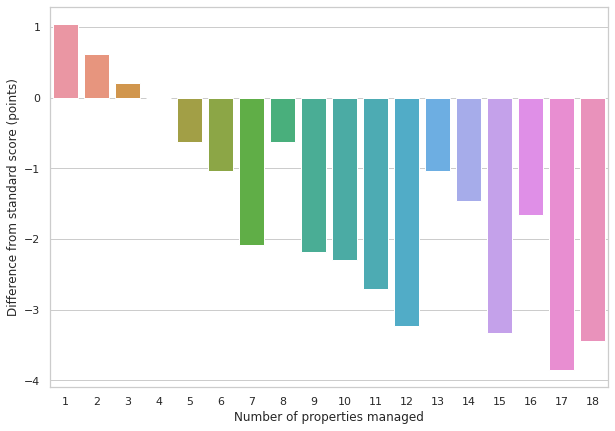

In [64]:
plt.figure(figsize=(10,7))
sns.barplot(data=plot_manage, x='host_listings_count', y='diff_fr_std')
plt.xlabel('Number of properties managed')
plt.ylabel('Difference from standard score (points)')
plt.show()

Based on the above graph, hosts that manage 4 listings or below are doing great as their scores are equal or even 1% higher to the standard score. <br>
Meanwhile, when the number of properties one host manages is from 4 and up to 18, the rating scores are much lower than standard score from 0.6% till 3.9%. 

For further analysis, we will take a deep dive into the variable `host_listings_count` to see whether there is any patterns with other variables. <br>
First, we are curious that whether experienced hosts manage multiple properties better than regular hosts? <br>
One factor that helps explain it is to make a reference to `superhost` badge status. 

In [65]:
plot_superhost = df_manage.groupby(['host_listings_count', 'superhost']).agg({'rs_value':'median', 'id':'count'}).reset_index()

In [66]:
plot_superhost

,host_listings_count,superhost,rs_value,id
0,1.0,f,4.800,2140
1,1.0,t,4.880,1773
2,2.0,f,4.760,1060
3,2.0,t,4.860,978
4,3.0,f,4.710,666
5,3.0,t,4.850,658
6,4.0,f,4.750,492
7,4.0,t,4.840,366
8,5.0,f,4.680,355
9,5.0,t,4.830,333


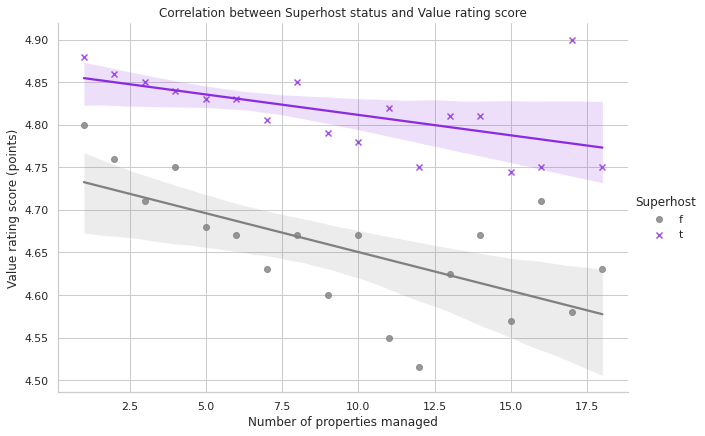

In [67]:
g = sns.lmplot(data=plot_superhost, x='host_listings_count', y='rs_value', hue='superhost', markers=['o', 'x'], 
           height=6, aspect=1.5, palette=dict(f='grey', t='blueviolet'))
plt.title('Correlation between Superhost status and Value rating score')
plt.xlabel('Number of properties managed')
plt.ylabel('Value rating score (points)')
g._legend.set_title('Superhost')
plt.show()

Despite of the fact that hosts with more properties to be managed tend to get lower value rating score, hosts with Superhost badge maintain a relatively high score of value rating over the regular hosts. <br> 
This can be understandable if we refer to the requirements that Airbnb set for a host to get this badge: 
- Completed at least 10 trips or 3 reservations that total at least 100 nights
- Maintained a 4.8 overall rating <br>

As they are all experienced ones getting very positive response from guests, they are surely the ones who spent their time in paying much attention to every single details in their listings to fulfill guests' demand and expectation regardless of how many listings they are controlling at once.

Another factor that we are about to discover is a feature called "Instant Book". This has been promoted by Airbnb as a feature that helps:
- boosting the earnings 
- improving the ranking in search results
- making hosts feel convenient as they do not have to respond to every request <br>

We will see how guests are evaluating the hosts with multiple properties when they turn on or off this "instant book" feature. 

In [68]:
plot_instant = df_manage.groupby(['host_listings_count', 'instant_bookable']).agg({'rs_value':'median', 'id':'count'}).reset_index()

In [69]:
plot_instant

,host_listings_count,instant_bookable,rs_value,id
0,1.0,f,4.860,2799
1,1.0,t,4.840,1114
2,2.0,f,4.840,1368
3,2.0,t,4.790,670
4,3.0,f,4.820,856
5,3.0,t,4.785,468
6,4.0,f,4.820,501
7,4.0,t,4.790,357
8,5.0,f,4.780,409
9,5.0,t,4.750,279


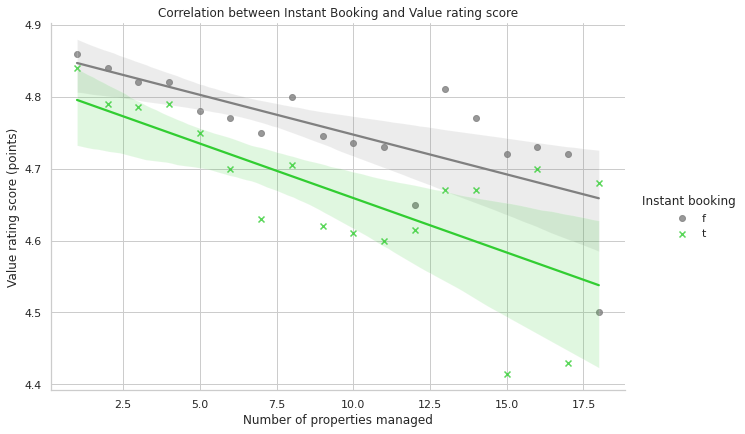

In [70]:
g = sns.lmplot(data=plot_instant, x='host_listings_count', y='rs_value', hue='instant_bookable', markers=['o', 'x'], 
           height=6, aspect=1.5, palette=dict(f='grey', t='limegreen'))
plt.title('Correlation between Instant Booking and Value rating score')
plt.xlabel('Number of properties managed')
plt.ylabel('Value rating score (points)')
g._legend.set_title('Instant booking')
plt.show()

Although the discrepancy in value rating score between hosts using or not using this feature is not that much and the rating value keeps going down when hosts manage too many properties, we can see an interesting trend here is that hosts turning on "instant book" have a lower value rating score than the ones that turned it off. 

This kind of fast booking in a short time can lead us to e-commerce are where there is a similar term with "instant book" here, which is called "flash sales". <br> 
Whenever there are flash sales on e-commerce websites, customers rush to it, find the ones they targeted and proceed payment immediately before they are sold out. But this selling strategy also has many serious consequences. 

Talking about this issue, there is one article named as "The Death of Flash Sales' published on Retail TouchPoints - an online publishing network for retail executives - said about how consumers leave negative comments on Facebook page of Gilt ([an US e-commerce website](https://www.gilt.com/boutique/)) as they disappointed with the ones they purchased too fast: <br> <br>
***With 27% of negative Facebook comments targeting Gilt’s product, opulent quality in flash sale merchandise is on the outs and is shedding light on the rise of aged fabric.*** <br>
***But 45% of flash sale offers sell out before the shopper can even review their virtual shopping carts, according to research from Dotcom Distribution. This essentially leaves shoppers in the dust.*** <br> 

Mona Bijoor (CEO of JOOR). *Death of Flash Sales*. Retail TouchPoints. https://www.retailtouchpoints.com/blog/the-death-of-flash-sales

Back to the case of "Instant book", when guest book a listing in a short time, they tend to not pay much attention to details mentioned in the listing such the housing rule, check-in/out time, strict rule in one neighbourhood... And when they experience these in person, they may feel disappointed and blame it back to the hosts as the listings is not worth the money they have paid, which resulted into a low score of value rating. 

One factor to find out whether that listing is value for the money is about the amenites offered. "Amenties" is also the term that Airbnb stressed out and mentioned when they share tips to [earn great reviews from guests](https://www.airbnb.com/resources/hosting-homes/a/whats-expected-of-hosts-432). It is also the final factor in this scale of analysis. 

### Amenities

There is a lot of amenities a host would like to offer in their listings with a hope to meet guest's demand and expectation. But hosts are not sure which ones can bring benefits to guests and which ones would turn down their moods.

One basic thing can be taken as an example is how guests response to Free vs. Paid service, and we will talk about parking service at listings specifically. 

In [71]:
parking = ['Free parking on premises', 'Free street parking', 'Paid parking on premises', 'Paid parking off premises']
service = ['Free dryer', 'Free washer', 'Paid dryer', 'Paid washer']

In [72]:
all = parking + service

In [73]:
parking_list = []
service_list = []
tmp = {}

for i in range(len(parking)): 
    parking_list.append(df[df['amenities'].str.contains(parking[i])]['rs_value'].mean())
    service_list.append(df[df['amenities'].str.contains(service[i])]['rs_value'].mean())

tmp['rating'] = parking_list + service_list

rating = pd.DataFrame(tmp, index=all)

In [74]:
rating = rating.reset_index()
rating = rating.rename(columns={'index':'amenities'})
rating

,amenities,rating
0,Free parking on premises,4.722197
1,Free street parking,4.757958
2,Paid parking on premises,4.605913
3,Paid parking off premises,4.621625
4,Free dryer,4.786839
5,Free washer,4.782456
6,Paid dryer,4.707090
7,Paid washer,4.711494


In [75]:
rating_parking = rating.iloc[:4]
rating_parking = rating_parking.rename(columns={'amenities': 'parking_type', 'rating': 'rating_parking'})

In [76]:
rating_service = rating.iloc[5:]
rating_service = rating_service.rename(columns={'amenities': 'parking_type', 'rating': 'rating_service'})

In [77]:
rating_parking['group'] = rating_parking['parking_type'].apply(lambda x: 'free' if 'Free' in x else 'paid')
rating_service['group'] = rating_service['parking_type'].apply(lambda x: 'free' if 'Free' in x else 'paid')

In [78]:
compare_parking = pd.pivot_table(data=rating_parking.iloc[:,1:], 
                           index=None, 
                           columns='group', 
                           values='rating_parking', 
                           aggfunc='mean')

compare_parking['percentage_diff'] = ((compare_parking['free'] / compare_parking['paid']) - 1) * 100

In [79]:
compare_service = pd.pivot_table(data=rating_service.iloc[:,1:], 
                           index=None, 
                           columns='group', 
                           values='rating_service', 
                           aggfunc='mean')

compare_service['percentage_diff'] = ((compare_service['free'] / compare_service['paid']) - 1) * 100

In [80]:
compare_type = pd.concat([compare_parking, compare_service], axis=0)
compare_type = compare_type.reset_index()
compare_type

group,index,free,paid,percentage_diff
0,rating_parking,4.740078,4.613769,2.737645
1,rating_service,4.782456,4.709292,1.553617


As the result shows, 
- Rating of hosts that offer free parking services is nearly 3% higher than the ones asking guests to pay. 
- Same case applied to service section as hosts offering free dryer, washer in their listings get 1.6% higher in value rating score than hosts do not have free service policy. <br>

In general, all guests love free services, which results into a high value of rating. 

Let's talk about the travel after pandemic. There is a lot of new trends appear after a long time of isolation in a same place from time to time. As a result, people want to escape from their sweet homes and live in another place. As being mentioned in article published on Airbnb called ["Travel revolution in data"](https://news.airbnb.com/travel-revolution-in-data/), the author declared: "People increasingly are living on Airbnb. They want amenities for living, not just visiting." <br>
In the most searched-for amenities, in addition to extra services like pools, wifi, free parking or pets-allowed, surprisingly, kitchen is the one that guests are frequently looking for it (up 95% based on the article).

From the scale of this dataset, we are going to see how hosts are equiping kitchen in their listings and how guests' responses are. <br>
First, we find all the listings that listed out all Kitchen amenities and listings listed the word "Kitchen" only for comparison about listings supply and value rating score. 

In [81]:
all_kitchen = df[(df['amenities'].str.contains('Kitchen')) & 
   (df['amenities'].str.contains('Cooking basics')) & 
   (df['amenities'].str.contains('Dishes and silverware')) &
   (df['amenities'].str.contains('Coffee maker')) & 
   (df['amenities'].str.contains('Refrigerator')) &
   (df['amenities'].str.contains('Microwave'))]

In [82]:
only_kitchen = df[df['amenities'].str.contains('Kitchen')]

In [83]:
only_kitchen = only_kitchen[~only_kitchen['amenities'].str.contains('Cooking basics')]

In [84]:
only_kitchen = only_kitchen[~only_kitchen['amenities'].str.contains('Dishes and silverware')]

In [85]:
only_kitchen = only_kitchen[~only_kitchen['amenities'].str.contains('Coffee maker')]

In [86]:
only_kitchen = only_kitchen[~only_kitchen['amenities'].str.contains('Refrigerator')]

In [87]:
only_kitchen = only_kitchen[~only_kitchen['amenities'].str.contains('Microwave')]

Then, we can compute: 
- The number of listings in 2 groups: one included only "Kitchen" and one with Kitchen plus other cooking things.
- Average rating score in these 2 groups

In [88]:
kitchen_supply = all_kitchen.shape[0] + only_kitchen.shape[0]
kitchen_supply

9429

In [89]:
all_rate = all_kitchen.shape[0] / kitchen_supply * 100
only_rate = only_kitchen.shape[0] / kitchen_supply * 100

In [90]:
all_kitchen['rs_value'].mean()

4.74655323819978

In [91]:
only_kitchen['rs_value'].mean()

4.635617886178862

In [92]:
data = [only_rate, all_rate]
labels = ['No other kitchen amenities listed with 4.64 of average value rating', 
          'Other kitchen amenities listed with 4.75 of average value rating']

In [93]:
compare_kitchen = pd.DataFrame(data, index=labels).reset_index()
compare_kitchen = compare_kitchen.rename(columns={'index':'labels', 0:'percent_of_listings'})
compare_kitchen

,labels,percent_of_listings
0,No other kitchen amenities listed with 4.64 of...,13.044862
1,Other kitchen amenities listed with 4.75 of av...,86.955138


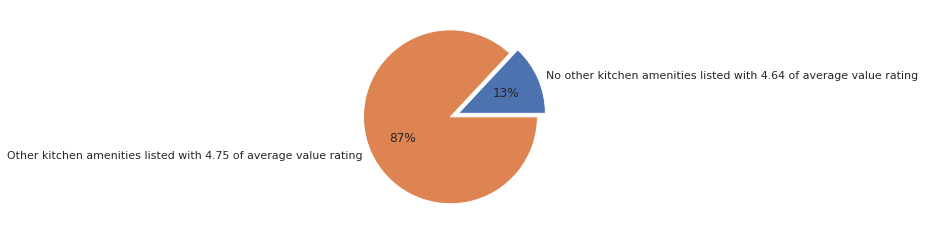

In [94]:
plt.pie(compare_kitchen['percent_of_listings'].values, labels=compare_kitchen['labels'], autopct='%.0f%%', explode=[0.05]*2)
plt.show()

Of the 9429 listings with kitchen listed in the Amenity section:
- Listings that included Kitchen and its relevant amenities have a high rating with 4.75 and there is 87% of listings that is currently advertised like that. <br> 
- The remained 13% of listings that included only "Kitchen" in amenity get lower rating score with 4.64 . <br>

This can be understandable from guest's perspective. If a host mentioned only "Kitchen" in the amenity without other equipments, guests still expect to get a full set of cooking things. And if the host did not provide at level the guests expected, they will have negative feelings, which leads to a low of value rating score. Therefore, hosts should mention in details what they can offer to avoid high expectation from guests and also help guests to be prepared by themselves. 

## Conclusion

- Guest's expectation can change with the listing size. Listings with larger sizes tend to have a wide range of price and guests would take it into consideration. Each of guest has different points of view of what is valuable to them based on what they received and rating score therefore will also be given subjectively. 
- When one place has too many listings, guests can have a wide range of choices for choosing based on their demands. That's when the comparisons come out and rating scores now are varied significantly. Additionally, properties in places with high density of listing can struggle to achieve a 4.8-score of rating than properties in places where listings are sparsely distributed. 
- If one host has too many properties to manage at once, they hardly catch up with little things in each listings, which may fail the guest's expectation. Moreover, there are also some interesting patterns to be found out as well: 
  - Superhosts, which are the experienced ones, tend to get over challenges of multiple listings management and meet the demand of guest much more easily.
  - Host with multiple listings tend to turn on "instant book" to help with response rate improvement. However, this can be a double-edged sword as when the guest book a listing to fast, they tend to ignore things and there is a high chance those are the important ones that host would like to notice guests in advance. This behaviour can be resulted into disappointment after they experienced in persons and can hurt the reputation of hosts eventually. 
- Amenities play a critical role in adding value to listing, especially the free ones. Additionally, hosts should be specific in what amenities they can offer in order to avoid high expectation from guests. 


# Export to Google Sheet Report

In [ ]:
# Mount to Google Sheets 
from google.colab import auth
auth.authenticate_user()

# Import neccessary libraries -- Đi học syntax 
import gspread
from google.auth import default
creds, _ = default()
from gspread_dataframe import set_with_dataframe

# Authorize Google Sheets API
gc = gspread.authorize(creds)

In [ ]:
# Create a new Google Spreadsheets
sh = gc.create('airbnb_value_analysis_final')

Tables to export: 
- Size of listing: 
  - plot_acc (regplot)
  - df_size (boxplot)
  - acc_neighbourhood_compare
  - df_acc2 & df_acc16 (boxplot comparison)
- Density:
  - rounded_density (regplot)
  - grouped_density (barplot)
- Multiple properties:
  - plot_manage (regplot + barplot)
  - plot_superhost (regplot)
  - plot_instant (regplot)
- Amenities:
  - rating
  - compare_type
  - compare_kitchen

In [ ]:
def export_data_to_new_sheet(gsheet_key, worksheet_name, data):

    sh = gc.open_by_key(gsheet_key)
    
    # To create a new worksheet with 1000 rows and 26 columns
    worksheet = sh.add_worksheet(worksheet_name, 20000, 26)

    # For writing to an existing worksheet
    # worksheet = sh.get_worksheet(0) # --> to get the first worksheet

    set_with_dataframe(worksheet, data)

In [ ]:
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'corr_accommodates_rating', plot_acc)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'listing_size_all_dataset', df_size_short)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'accommodates_neighbourhood', acc_neighbourhood_compare)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'anaheim_data', anaheim_data)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'sherman_data', sherman_data)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'neighbourhood_overview', neighbourhood_overview)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'corr_density_rating', rounded_density)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'group_density', grouped_density)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'corr_manage_rating', plot_manage)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'corr_superhost', plot_superhost)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'corr_instant', plot_instant)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'amenities_rating', rating)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'compare_free_paid', compare_type)
export_data_to_new_sheet('1-ssj4XHfcLg1yiU3W0rzXbvp6MXh-jZxh-2CNSRGUIM', 'compare_kitchen', compare_kitchen)